# Explore benchmark results

This notebook help to explore benchmark results and generate plots.

In [52]:
# Install dependencies
# !pip install numpy matplotlib

In [53]:
# Import required modules
import json
import re
from collections import defaultdict
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

In [54]:
# Load add JSON-lines result files
test_campaigns = []
for json_filename in glob("pytest_reports/*.json"):
    with open(json_filename, "rt") as fd:
        test_campaigns.append(json.load(fd))
print(f"{len(test_campaigns)} test campaigns loaded")

sessions = []
for json_filename in glob("*.json"):
    with open(json_filename, "rt") as fd:
        for line in fd:
            sessions.append(json.loads(line))
print(f"{len(sessions)} sessions loaded")

3 test campaigns loaded
993 sessions loaded


In [55]:
# Print one session to show document schema
print(json.dumps(sessions[0], indent=4))

{
    "test_case": "curl-openssl",
    "dump_method": "full-full",
    "session_idx": 1,
    "session_idx_max": 1,
    "traffic_dump_filepath": "/dumps/2023-01-20_09-00-42_104.154.89.105_1012_10.226.0.2_41106.pcap",
    "tls_client_random": "de489dbb6e688add1cdd0e91fe34ccdd2096844afdd90e1ed83327fc72ecb963",
    "pid": 3676116,
    "command": "curl",
    "command_sha256": "3d04ef018d83cbb379c62646c43aadd19c94404821e3ecd3d79fef9af9771d20",
    "diff_size_kB": 68,
    "platform": "Linux-5.15.0-58-generic-x86_64-with-glibc2.29",
    "system": "Linux",
    "machine": "x86_64",
    "version": "#64~20.04.1-Ubuntu SMP Fri Jan 6 16:42:31 UTC 2023",
    "timestamp": 1674205242.41526,
    "key_candidates_length": 19674,
    "freeze_duration_ms": 12.584115,
    "diff_duration_ms": 47.82366752624512,
    "entropy_filter_duration_ms": 855.4279804229736,
    "brute_force_duration_ms": 397.54796028137207,
    "modified_region_paths": [
        "/opt/curl-openssl/bin/curl",
        "[heap]",
        "/

In [56]:
dump_methods = ["full-full", "rst-partial", "rst-partial-rst", "full-partial", "full-partial-rst"]
curl_flavors = ["OpenSSL", "GnuTLS", "mBedTLS", "WolfSSL", "NSS", "BearSSL"]

test_cases = list(set((session["test_case"] for session in sessions)))

def get_sessions(session_filter):
    """
    {key: "regex"}, e.g., {"test_case": ".*openssl.*"}
    """
    _sessions = sessions.copy()
    for key, value in session_filter.items():
        _sessions = list(filter(lambda session: re.search(value, str(session[key])), _sessions))
    assert _sessions, f"No session with filter {session_filter}"
    return _sessions


In [57]:
count_success = defaultdict(int)
count_failure = defaultdict(int)

for test_campaign in test_campaigns:
    for test in test_campaign["tests"]:
        if test["nodeid"].startswith("benchmark/tests/curl/test_curl.py"):
            for _dump_method in dump_methods:
                for _curl_flavor in curl_flavors:
                    if f"{_curl_flavor}-{_dump_method}".lower() in test["nodeid"]:
                        if test["outcome"] == "passed":
                            count_success[f"{_curl_flavor}/{_dump_method}"] += 1
                        else:
                            count_failure[f"{_curl_flavor}/{_dump_method}"] += 1

for tls_lib_dump_method in count_success.keys():
    pct_success = round(100*count_success[tls_lib_dump_method] / (count_success[tls_lib_dump_method] + count_failure[tls_lib_dump_method]))
    lib, strategy = tls_lib_dump_method.split("/")
    print(f"{lib} & {strategy} & {pct_success}\\% \\\\")

OpenSSL & full-full & 100\% \\
OpenSSL & rst-partial & 100\% \\
OpenSSL & rst-partial-rst & 100\% \\
OpenSSL & full-partial & 100\% \\
OpenSSL & full-partial-rst & 100\% \\
GnuTLS & full-full & 100\% \\
GnuTLS & rst-partial & 100\% \\
GnuTLS & rst-partial-rst & 100\% \\
GnuTLS & full-partial & 100\% \\
GnuTLS & full-partial-rst & 100\% \\
mBedTLS & full-full & 100\% \\
mBedTLS & rst-partial & 100\% \\
mBedTLS & rst-partial-rst & 100\% \\
mBedTLS & full-partial & 100\% \\
mBedTLS & full-partial-rst & 100\% \\
WolfSSL & full-full & 100\% \\
WolfSSL & rst-partial & 100\% \\
WolfSSL & rst-partial-rst & 100\% \\
WolfSSL & full-partial & 100\% \\
WolfSSL & full-partial-rst & 100\% \\
NSS & full-full & 100\% \\
NSS & rst-partial & 100\% \\
NSS & rst-partial-rst & 100\% \\
NSS & full-partial & 100\% \\
NSS & full-partial-rst & 100\% \\
BearSSL & full-full & 100\% \\
BearSSL & rst-partial & 100\% \\
BearSSL & rst-partial-rst & 100\% \\
BearSSL & full-partial & 100\% \\
BearSSL & full-partial-rs

38 sessions for {'test_case': 'python_requests_series_10_sessions', 'session_idx': '10'}


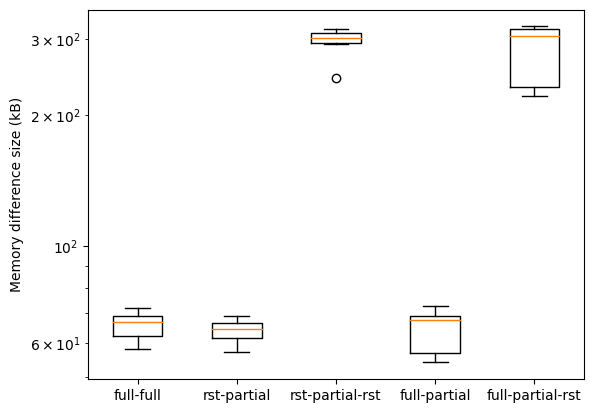

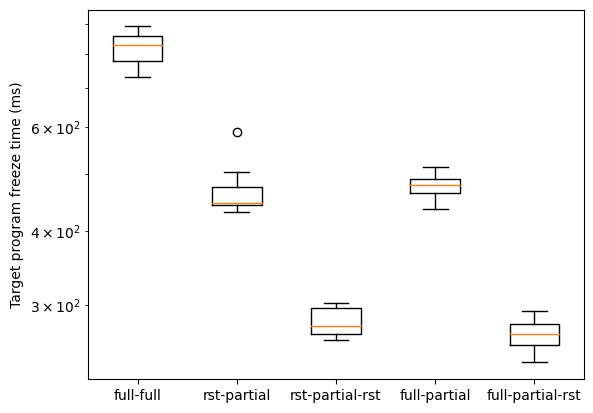

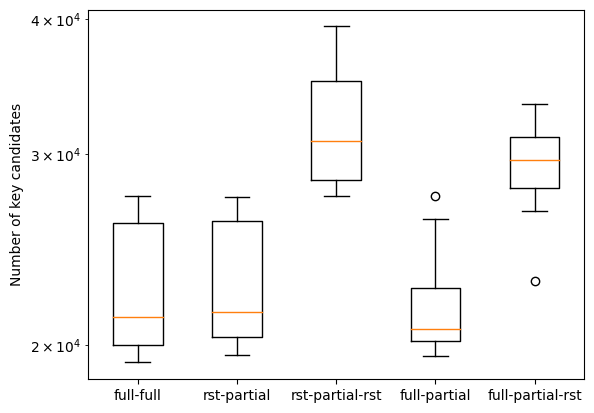

In [58]:
def print_stats(session_filter) -> None:
    _sessions = get_sessions(session_filter)
    print(f"{len(_sessions)} sessions for {session_filter}")
    
    diff_size = defaultdict(list)
    freeze_time = defaultdict(list)
    key_candidates_length = defaultdict(list)
    for session in _sessions:
        diff_size[session["dump_method"]].append(session["diff_size_kB"])
        freeze_time[session["dump_method"]].append(session["freeze_duration_ms"])
        key_candidates_length[session["dump_method"]].append(session["key_candidates_length"])
    plt.boxplot(
        [
            diff_size[dump_method]
            for dump_method in dump_methods
        ]
    )
    plt.yscale('log')
    plt.xticks(range(1,len(dump_methods)+1), dump_methods)
    plt.ylabel("Memory difference size (kB)")
    plt.show()
    
    plt.boxplot(
        [
            freeze_time[dump_method]
            for dump_method in dump_methods
        ]
    )
    plt.yscale('log')
    plt.xticks(range(1,len(dump_methods)+1), dump_methods)
    plt.ylabel("Target program freeze time (ms)")
    plt.show()
    
    plt.boxplot(
        [
            key_candidates_length[dump_method]
            for dump_method in dump_methods
        ]
    )
    plt.yscale('log')
    plt.xticks(range(1,len(dump_methods)+1), dump_methods)
    plt.ylabel("Number of key candidates")
    plt.show()
            
print_stats({"test_case": "python_requests_series_10_sessions", "session_idx": "10"})
#print_stats({"test_case": "curl-.*"})

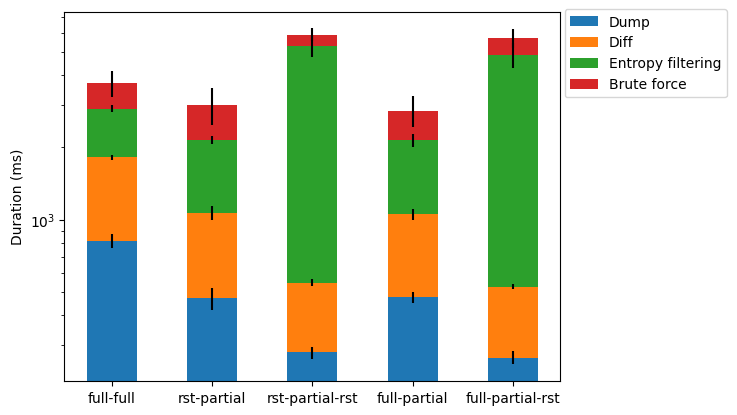

In [59]:
def print_durations(session_filter):
    _sessions = get_sessions(session_filter)
    
    labels = {
        "freeze_duration_ms": "Dump",
        "diff_duration_ms": "Diff",
        "entropy_filter_duration_ms": "Entropy filtering",
        "brute_force_duration_ms": "Brute force"
    }
    width = 0.5

    avg, std = {}, {}
    for label in labels.keys():
        avg[label], std[label] = [], []
        for dump_method in dump_methods:
            avg[label].append(np.average([session[label] for session in _sessions if session["dump_method"] == dump_method]))
            std[label].append(np.std([session[label] for session in _sessions if session["dump_method"] == dump_method]))

    fig, ax = plt.subplots()

    ax.bar(
        dump_methods,
        avg["freeze_duration_ms"],
        width,
        yerr=std["freeze_duration_ms"],
        label=labels["freeze_duration_ms"]
    )
    ax.bar(
        dump_methods,
        avg["diff_duration_ms"],
        width,
        yerr=std["diff_duration_ms"],
        bottom=avg["freeze_duration_ms"],
        label=labels["diff_duration_ms"]
    )
    ax.bar(
        dump_methods,
        avg["entropy_filter_duration_ms"],
        width,
        yerr=std["entropy_filter_duration_ms"],
        bottom=np.array(avg["freeze_duration_ms"]) + np.array(avg["diff_duration_ms"]),  # elem by elem sum
        label=labels["entropy_filter_duration_ms"]
    )
    ax.bar(
        dump_methods,
        avg["brute_force_duration_ms"],
        width,
        yerr=std["brute_force_duration_ms"],
        bottom=np.array(avg["freeze_duration_ms"]) + np.array(avg["diff_duration_ms"]) + np.array(avg["entropy_filter_duration_ms"]),
        label=labels["brute_force_duration_ms"]
    )

    ax.set_ylabel("Duration (ms)")
    ax.legend(bbox_to_anchor=(1.35, 1.025))

    plt.yscale('log')
    plt.show()

print_durations({"test_case": "python_requests_series_10_sessions", "session_idx": "10"})

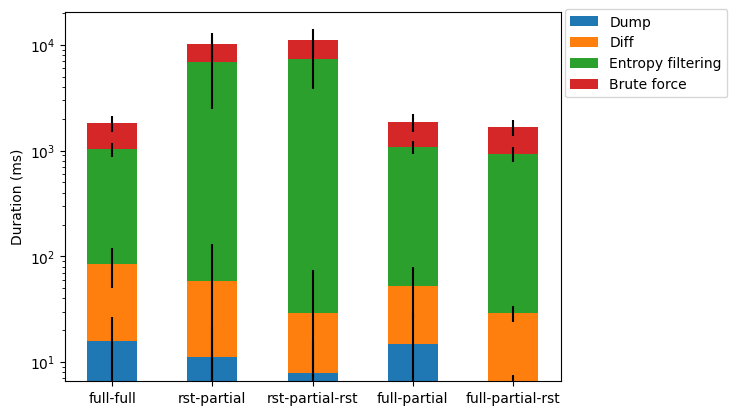

In [60]:
print_durations({"test_case": "curl-openssl"})

In [63]:
for session in sessions:
    if session["baseline"]:
        print(
            session["test_case"],
            session["key_candidates_length"],
            session["baseline"]["original_key_candidates_count"],
            session["baseline"]["entropy_filter_key_candidates_count"],
            round(100 * session["key_candidates_length"] / session["baseline"]["entropy_filter_key_candidates_count"])
        )

# Appendices

## Entropies of secret keys

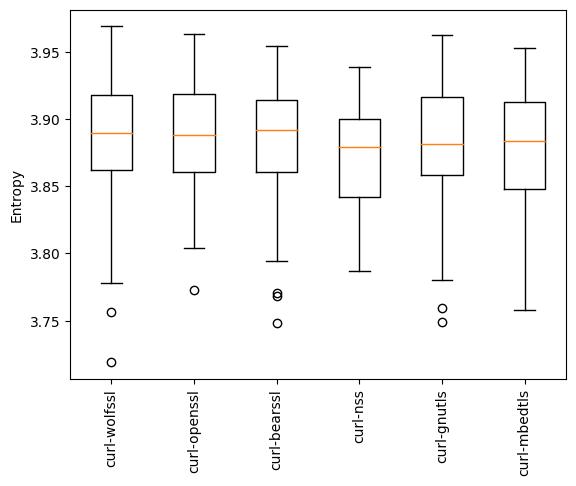

In [116]:
import math

def entropy(string: str) -> float:
    """
    Calculates the Shannon entropy of a string
    """
    prob = [float(string.count(c)) / len(string) for c in dict.fromkeys(list(string))]
    return -sum([p * math.log(p) / math.log(2.0) for p in prob])

def plot_entropies(session_filter) -> None:
    _sessions = get_sessions(session_filter)
    _test_cases = list(set((session["test_case"] for session in _sessions)))

    entropies = defaultdict(list)  # test_case: [entropies]
    for session in _sessions:
        # TLS 1.2
        master_key = session.get("tls1.2", {}).get("master_key")
        if master_key:
            entropies[session["test_case"]].append(entropy(master_key))
        # TLS 1.3
        client_secret_key = session.get("tls1.3", {}).get("client_secret_key")
        server_secret_key = session.get("tls1.3", {}).get("server_secret_key")
        if client_secret_key and server_secret_key:
            entropies[session["test_case"]].append(entropy(client_secret_key))
            entropies[session["test_case"]].append(entropy(server_secret_key))
        
    plt.boxplot(
        [
            entropies[test_case]
            for test_case in entropies
        ]
    )
    plt.xticks(range(1,len(_test_cases)+1), _test_cases, rotation=90)
    # plt.xlabel("Test case")
    plt.ylabel("Entropy")
    # plt.title(f"Entropy per test case for {len(_sessions)} sessions")
    plt.show()

plot_entropies({"test_case": "curl.*"})